In [2]:
from sentinel_hub_utils import call_s2l2a_api
import numpy as np
import psutil
import os
import gc
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [3]:
from itertools import product
from typing import Tuple
import cv2
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import tempfile

# returns array of aerial and array of satellite image tiles
def tile_drone_sat_pair(chunk_path: str, image_size=128) -> Tuple[np.ndarray, np.ndarray]:
    name = chunk_path.split('/')[-1]
    print(f"Processing {name}...")
    
    name_list = name.split(' ')
    rgb_name = "Chunk" + name_list[1]
    rgb_name += ".tif"

    # for folder 'Chunk 1/' rgb_path should be 'Chunk1.tif' and satellite_path should be 'satellite.tif'
    rgb_path = os.path.join(chunk_path, rgb_name)
    satellite_path = os.path.join(chunk_path, "satellite.tif")
    
    # read tiff and resize satellite tiff
    rgb_data, _ = read_tiff(rgb_path)
    satellite_data, _ = read_tiff(satellite_path)
    satellite_data = resize_satellite_data(rgb_data, satellite_data)
    assert satellite_data.shape[1] == rgb_data.shape[1] and satellite_data.shape[2] == rgb_data.shape[2], "Drone data and satellite data have different widths and heights"

    # Ensure we are only using the first three channels (RGB)
    if rgb_data.shape[0] > 3:
        rgb_data = rgb_data[:3, :, :]

    # Create pairs of tiles
    drone_images, satellite_images = create_drone_sat_pairs(rgb_data, satellite_data, image_size)

    assert len(drone_images) == len(satellite_images), "Number of drone images and satellite images do not match."
    print(f"Number of valid pairs: {len(drone_images)}")
    
    return drone_images, satellite_images

def read_tiff(tif_path):
    with rasterio.open(tif_path) as src:
        data = src.read()
        meta = src.meta
    return data, meta

def tile_generator(data, tile_size):
    nrows, ncols = data.shape[1], data.shape[2]
    for i, j in product(range(0, nrows, tile_size), range(0, ncols, tile_size)):
        if i + tile_size <= nrows and j + tile_size <= ncols:
            yield data[:, i:i+tile_size, j:j+tile_size], (i, j)

def create_drone_sat_pairs(rgb_data, satellite_data, tile_size) -> Tuple[np.ndarray, np.ndarray]:
    drone_images = []
    satellite_images = []

    for idx, ((rgb_tile, _), (satellite_tile, (i, j))) in enumerate(zip(tile_generator(rgb_data, tile_size), tile_generator(satellite_data, tile_size))):
        drone_images.append(rgb_tile[:3, :, :])  # Keep only the first three channels (RGB)
        satellite_images.append(satellite_tile)

    # Convert lists to numpy arrays
    drone_images = np.array(drone_images)
    satellite_images = np.array(satellite_images)
    
    # Ensure images and labels have the same length
    assert drone_images.shape[0] == satellite_images.shape[0], "Mismatch in number of drone images and satellite images"
    
    return drone_images, satellite_images

# resize satellite image to match aerial image height and width
def resize_satellite_data(drone_data, satellite_data):
    _, H_drone, W_drone = drone_data.shape
    satellite_resized = np.stack([
        cv2.resize(
            satellite_data[i],
            (W_drone, H_drone),
            interpolation=cv2.INTER_CUBIC
        )
        for i in range(satellite_data.shape[0])
    ], axis=0)

    assert drone_data.shape[1] == satellite_resized.shape[1] and drone_data.shape[2] == satellite_resized.shape[2], "Mismatch in number of images and labels"

    return satellite_resized

# naip tifs seem to have CRS of NAD83
# we want to reproject to CRS of WGS84 UTM
# reprojects file in place
def reproject_nad83_to_wgs84_utm(chunk_path):
    name = chunk_path.split('/')[-1]
    # Get tiff path
    name_list = name.split(' ')
    tiff_name = "Chunk" + name_list[1]
    tiff_name += ".tif"
    tiff_path = os.path.join(chunk_path, tiff_name)

    with rasterio.open(tiff_path) as src:
        src_epsg = src.crs.to_epsg()

        # If we're already in WGS84 UTM (32601–32660 or 32701–32760), do nothing
        if 32601 <= src_epsg <= 32660 or 32701 <= src_epsg <= 32760:
            print(f"{os.path.basename(tiff_path)} already in WGS84 UTM (EPSG:{src_epsg}), skipping.")
            return

        # Otherwise, assume it must be NAD83 UTM (26901–26960)
        if not (26901 <= src_epsg <= 26960):
            raise ValueError(f"Unexpected source CRS EPSG:{src_epsg}, not in NAD83 UTM nor WGS84 UTM ranges")
        
        # Figure out the UTM zone and hemisphere from the NAD83 code:
        if 26901 <= src_epsg <= 26960:
            zone = src_epsg - 26900
            is_northern = True
        elif 32701 <= src_epsg <= 32760:
            zone = src_epsg - 32700
            is_northern = False

        # Build target WSG84 UTM code
        target_epsg = (32600 if is_northern else 32700) + zone
        dst_crs = CRS.from_epsg(target_epsg)

        print(f"Reprojecting {os.path.basename(tiff_path)} from NAD83 UTM (EPSG:{src_epsg}) to WGS84 UTM (EPSG:{target_epsg})")
        transform, width, height = calculate_default_transform(
          src.crs, dst_crs, src.width, src.height, *src.bounds, densify_pts=200
        )

        # update dst metadata
        dst_meta = src.meta.copy()
        dst_meta.update({
          "crs": dst_crs,
          "transform": transform,
          "width": width,
          "height": height,
        })

        # create temp file and reproject to temp
        with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
          tmp_path = tmp.name
        with rasterio.open(tmp_path, 'w', **dst_meta) as dst:
          for i in range(1, src.count + 1):
            reproject(
              source=rasterio.band(src, i),
              destination=rasterio.band(dst, i),
              src_transform=src.transform,
              src_crs=src.crs,
              dst_transform=transform,
              dst_crs=dst_crs,
              resampling = Resampling.bilinear,
              src_nodata = src.nodata,
              dst_nodata = src.nodata,
            )
    os.replace(tmp_path, tiff_path)

In [6]:
# scaled_base_path is base path of all scaled Chunk folders
# assumes NAIP is already scaled to 1m / pixel resolution
scaled_base_path = "/home/a.jajodia.229/mangrove/local_data/one_meter_naip"

TILE_SIZE = 224

combined_drone_file = os.path.join(scaled_base_path, f'{TILE_SIZE}naip_dataset_drone.npy')
combined_satellite_file = os.path.join(scaled_base_path, f'{TILE_SIZE}naip_dataset_satellite.npy')

# RAM thresholds
TOTAL_RAM_MB = psutil.virtual_memory().total / (1024 ** 2)
SAFE_RAM_USAGE_MB = TOTAL_RAM_MB - 16 * 1024  # 16GB below total RAM
CHUNK_BUFFER_SIZE = 5  # Number of chunks to keep in memory at a time

In [10]:
# Generate satellite.tif for all scaled Chunk folders
for entry in os.listdir(scaled_base_path):
    if 'Chunk' in entry:
        chunk_path = os.path.join(scaled_base_path, entry)

        reproject_nad83_to_wgs84_utm(chunk_path)

        call_s2l2a_api(chunk_path) # create satellite.tif

print('\nDone')

Chunk1.tif already in WGS84 UTM (EPSG:32617), skipping.
/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 1 epsg_code=32617
Querying SentinelHub API for Chunk 1
✅ TIFF file saved as '/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 1/satellite.tif'

Reprojecting Chunk2.tif from NAD83 UTM (EPSG:26917) to WGS84 UTM (EPSG:32617)
/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 2 epsg_code=32617
Querying SentinelHub API for Chunk 2
✅ TIFF file saved as '/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 2/satellite.tif'

Reprojecting Chunk3.tif from NAD83 UTM (EPSG:26917) to WGS84 UTM (EPSG:32617)
/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 3 epsg_code=32617
Querying SentinelHub API for Chunk 3
✅ TIFF file saved as '/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 3/satellite.tif'

Reprojecting Chunk4.tif from NAD83 UTM (EPSG:26917) to WGS84 UTM (EPSG:32617)
/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chun

Array shape: (4, 7554, 6789)
Count (bands): 4
Driver: GTiff
CRS: EPSG:32617
Bounds: BoundingBox(left=555069.999999802, bottom=3076259.0000901977, right=561858.9999998752, top=3083813.000090279)


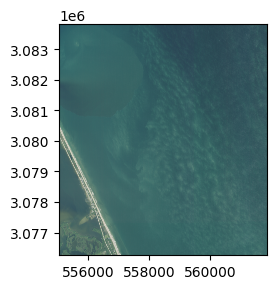

In [12]:
with rasterio.open('/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 1/Chunk1.tif') as f:
    arr = f.read()
    print(f"Array shape: {arr.shape}")
    print(f"Count (bands): {f.count}")
    print(f"Driver: {f.driver}")
    print(f"CRS: {f.crs}")
    print(f"Bounds: {f.bounds}")
    # print(f"Pixel counts: {pixel_value_counts(arr)}")
    fig, ax = plt.subplots(figsize=(3, 3))
    show(f, ax=ax)

Array shape: (4, 7554, 6789)
Count (bands): 4
Driver: GTiff
CRS: EPSG:32617
Bounds: BoundingBox(left=555069.999999802, bottom=3076259.0000901977, right=561858.9999998752, top=3083813.000090279)


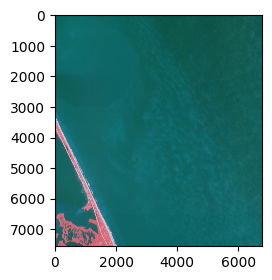

In [14]:
with rasterio.open('/home/a.jajodia.229/mangrove/local_data/one_meter_naip/Chunk 1/Chunk1.tif') as f:
    arr = f.read()
    print(f"Array shape: {arr.shape}")
    print(f"Count (bands): {f.count}")
    print(f"Driver: {f.driver}")
    print(f"CRS: {f.crs}")
    print(f"Bounds: {f.bounds}")
    fig, ax = plt.subplots(figsize=(3, 3))
    rgb_arr = f.read([4, 3, 2])
    show(rgb_arr, ax=ax)

In [15]:
# Functions to monitor memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

In [16]:
"""
Convert all tif pairs into tiled datasets

NOTE: This will take a lot of time, memory, and storage space.
You should have at least 32GB of RAM and triple the chunk folder size of storage. If you don't have enough RAM,
you can run this script in smaller chunks by lowering the CHUNK_BUFFER_SIZE variable.
"""

# Function to append data to memory-mapped file
def append_to_memmap(file_path, data, dtype):
    if not os.path.exists(file_path):
        print(f"Creating new memmap file at {file_path}")
        new_memmap = np.lib.format.open_memmap(file_path, mode='w+', dtype=dtype, shape=data.shape)
        new_memmap[:] = data
    else:
        # Load the existing memmap
        memmap = np.load(file_path, mmap_mode='r+')
        new_shape = (memmap.shape[0] + data.shape[0],) + memmap.shape[1:]
        
        # Create a temporary memmap with the expanded size
        temp_file_path = file_path + '.tmp'
        new_memmap = np.lib.format.open_memmap(temp_file_path, mode='w+', dtype=dtype, shape=new_shape)
        
        # Copy old data into the temporary memmap
        new_memmap[:memmap.shape[0]] = memmap[:]
        
        # Append new data
        new_memmap[memmap.shape[0]:] = data
        
        # Flush and delete the old memmap
        del memmap
        new_memmap.flush()
        
        # Replace the original file with the temporary file
        os.replace(temp_file_path, file_path)

# Buffer for storing data before appending to memmap
drone_buffer = []
satellite_buffer = []

num_chunks = len([entry for entry in os.listdir(scaled_base_path) if 'Chunk' in entry])
print(f"Processing {num_chunks} chunk directories")

# Iterate over each chunk directory and process TIFF pairs
current_chunk = 0
for entry in os.listdir(scaled_base_path):
    if 'Chunk' in entry:
        current_chunk += 1
        print(f"\nChunk {current_chunk}/{num_chunks}")
        chunk_path = os.path.join(scaled_base_path, entry)
        
        # Generate tiled images and labels
        drone_images, satellite_images = tile_drone_sat_pair(chunk_path, image_size=TILE_SIZE)
        if drone_images.shape[0] == 0:
            print(f"No valid tiles found at {entry}")
            continue
        
        # Add to buffer
        drone_buffer.append(drone_images)
        satellite_buffer.append(satellite_images)

        # Check memory usage and append to memmap if within threshold
        current_memory_usage = get_memory_usage()
        if current_memory_usage > SAFE_RAM_USAGE_MB or current_chunk % CHUNK_BUFFER_SIZE == 0:
            if current_memory_usage > SAFE_RAM_USAGE_MB:
                print(f"Memory usage {current_memory_usage:.2f} MB exceeds {SAFE_RAM_USAGE_MB} threshold. Appending to memmap.")
            else:
                print("Appending to memmap...")
            drone_to_append = np.concatenate(drone_buffer, axis=0)
            satellite_to_append = np.concatenate(satellite_buffer, axis=0)
            append_to_memmap(combined_drone_file, drone_to_append, np.uint8)
            append_to_memmap(combined_satellite_file, satellite_to_append, np.uint8)
            
            # Clear buffer
            drone_buffer = []
            satellite_buffer = []
            
            # Memory management
            print_memory_usage()
            del drone_to_append, satellite_to_append
            gc.collect()

# Final append if buffer is not empty
if drone_buffer:
    print("Appending remaining buffered data to memmap.")
    drone_buffer = np.concatenate(drone_buffer, axis=0)
    satellite_buffer = np.concatenate(satellite_buffer, axis=0)
    append_to_memmap(combined_drone_file, drone_buffer, np.uint8)
    append_to_memmap(combined_satellite_file, satellite_buffer, np.uint8)
    
    # Clear buffer
    drone_buffer = []
    satellite_buffer = []

print('\nDone tiling tif pairs')

Processing 46 chunk directories

Chunk 1/46
Processing Chunk 1...
Number of valid pairs: 990

Chunk 2/46
Processing Chunk 2...
Number of valid pairs: 990

Chunk 3/46
Processing Chunk 3...
Number of valid pairs: 990

Chunk 4/46
Processing Chunk 4...
Number of valid pairs: 990

Chunk 5/46
Processing Chunk 5...
Number of valid pairs: 990
Appending to memmap...
Creating new memmap file at /home/a.jajodia.229/mangrove/local_data/one_meter_naip/224naip_dataset_drone.npy
Creating new memmap file at /home/a.jajodia.229/mangrove/local_data/one_meter_naip/224naip_dataset_satellite.npy
Memory Usage: 5629.62 MB

Chunk 6/46
Processing Chunk 6...
Number of valid pairs: 990

Chunk 7/46
Processing Chunk 7...
Number of valid pairs: 990

Chunk 8/46
Processing Chunk 8...
Number of valid pairs: 990

Chunk 9/46
Processing Chunk 9...
Number of valid pairs: 990

Chunk 10/46
Processing Chunk 10...
Number of valid pairs: 990
Appending to memmap...
Memory Usage: 5347.14 MB

Chunk 11/46
Processing Chunk 11...
Nu

In [19]:
drone_images = np.load('/home/a.jajodia.229/mangrove/local_data/one_meter_naip/224naip_dataset_drone.npy', mmap_mode='r+')
satellite_images = np.load('/home/a.jajodia.229/mangrove/local_data/one_meter_naip/224naip_dataset_satellite.npy', mmap_mode='r+')

print(f"Drone dataset shape={drone_images.shape}")
print(f"Satellite dataset shape={satellite_images.shape}")

Drone dataset shape=(45540, 3, 224, 224)
Satellite dataset shape=(45540, 12, 224, 224)


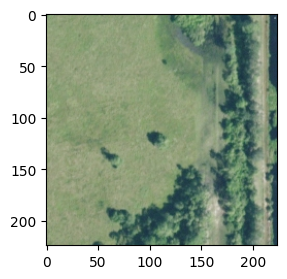

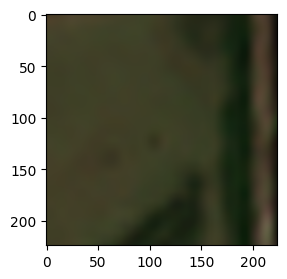

In [23]:
# Plot individual tile
idx = 30000
plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(drone_images[idx], (1, 2, 0)))

plt.figure(figsize=(3, 3))
satellite_rgb = satellite_images[idx][[3, 2, 1], :, :]
plt.imshow(np.transpose(satellite_rgb, (1, 2, 0)))